# CS5630, Group 3

**Data Preparation**

In [2]:
import pandas as pd
import plotnine as p9
from plotnine import ggplot, aes, geom_histogram, geom_bar, theme, element_text, geom_point,\
    scale_x_discrete, scale_fill_manual, labs
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# San Francisco

## Load the data

Up to now I am working with train subset

In [3]:
train = pd.read_csv("../data/external/sf-crime/train.csv")
train

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541
...,...,...,...,...,...,...,...,...,...
878044,2003-01-06 00:15:00,ROBBERY,ROBBERY ON THE STREET WITH A GUN,Monday,TARAVAL,NONE,FARALLONES ST / CAPITOL AV,-122.459033,37.714056
878045,2003-01-06 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,INGLESIDE,NONE,600 Block of EDNA ST,-122.447364,37.731948
878046,2003-01-06 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,SOUTHERN,NONE,5TH ST / FOLSOM ST,-122.403390,37.780266
878047,2003-01-06 00:01:00,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Monday,SOUTHERN,NONE,TOWNSEND ST / 2ND ST,-122.390531,37.780607


In [4]:
train.columns

Index(['Dates', 'Category', 'Descript', 'DayOfWeek', 'PdDistrict',
       'Resolution', 'Address', 'X', 'Y'],
      dtype='object')

In [5]:
train.dtypes

Dates          object
Category       object
Descript       object
DayOfWeek      object
PdDistrict     object
Resolution     object
Address        object
X             float64
Y             float64
dtype: object

## Selecting Fields

**Description** and **Resolution** columns are not required for us, dropping

In [158]:
train.drop(columns=["Descript", "Resolution"], inplace=True)
train.columns

Index(['Dates', 'Category', 'DayOfWeek', 'PdDistrict', 'Address', 'X', 'Y'], dtype='object')

Extracting different date fileds from **Dates** column

### Date

In [159]:
train["Dates"] = pd.to_datetime(train["Dates"])
train["year"] = train.Dates.dt.year
train["month"] = train.Dates.dt.month
train["day"] = train.Dates.dt.day
train["hour"] = train.Dates.dt.hour
train["DayOfWeek"] = train["Dates"].dt.dayofweek

### Address and Streets

Adress field usualy shows the intersection of two streets:

In [160]:
train["Address"]

0                 OAK ST / LAGUNA ST
1                 OAK ST / LAGUNA ST
2          VANNESS AV / GREENWICH ST
3           1500 Block of LOMBARD ST
4          100 Block of BRODERICK ST
                     ...            
878044    FARALLONES ST / CAPITOL AV
878045          600 Block of EDNA ST
878046            5TH ST / FOLSOM ST
878047          TOWNSEND ST / 2ND ST
878048      1800 Block of NEWCOMB AV
Name: Address, Length: 878049, dtype: object

It make sense to extract these streets and treat them sperately:

In [161]:
train["street1"] = train["Address"].str.split("/").str.get(0).str.strip()
train["street2"] = train["Address"].str.split("/").str.get(1).str.strip()

Trying to extract most 200 most crimincal streets

In [162]:
str1_counts = train["street1"].value_counts().head(200)
train["str1"] = train.apply(lambda r: 
                                     r["street1"] if r["street1"] in str1_counts.index else "other", axis=1)

str2_counts = train["street2"].value_counts().head(200)
train["str2"] = train.apply(lambda r: 
                                     r["street2"] if r["street2"] in str2_counts.index else "other", axis=1)

Here are cummulative plots 

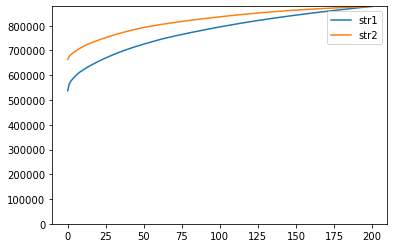

In [163]:
plt.plot(np.cumsum(train["str1"].value_counts().to_numpy()), label = "str1")
plt.plot(np.cumsum(train["str2"].value_counts().to_numpy()), label = "str2")
plt.ylim(0, train.shape[0])
plt.legend()

### Dropping strange coordinates

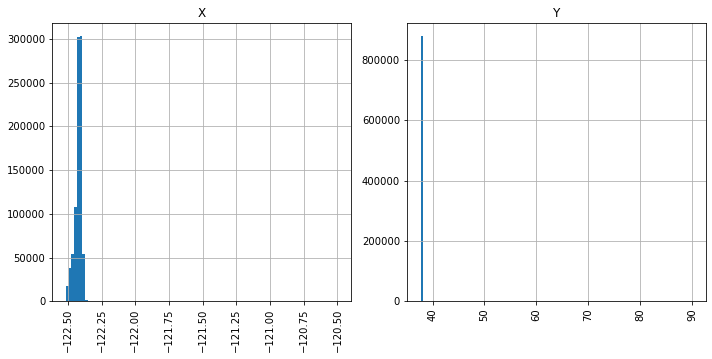

In [164]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (10, 5))
train["X"].hist(bins = 100, xrot = 90, ax=axes[0])
axes[0].set_title("X")
train["Y"].hist(bins = 100, xrot = 90, ax=axes[1])
axes[1].set_title("Y")
plt.tight_layout()

As you can see, the main part of the points have X<122.25, Y<40

There are, however, 67 points with strange coordinates

In [165]:
train.query("X>-122.25")

,Dates,Category,DayOfWeek,PdDistrict,Address,X,Y,year,month,day,hour,street1,street2,str1,str2
660485,2005-12-30 17:00:00,LARCENY/THEFT,4,TENDERLOIN,5THSTNORTH ST / OFARRELL ST,-120.5,90.0,2005,12,30,17,5THSTNORTH ST,OFARRELL ST,other,OFARRELL ST
660711,2005-12-30 00:34:00,ASSAULT,4,BAYVIEW,JAMESLICKFREEWAY HY / SILVER AV,-120.5,90.0,2005,12,30,0,JAMESLICKFREEWAY HY,SILVER AV,other,SILVER AV
660712,2005-12-30 00:34:00,ASSAULT,4,BAYVIEW,JAMESLICKFREEWAY HY / SILVER AV,-120.5,90.0,2005,12,30,0,JAMESLICKFREEWAY HY,SILVER AV,other,SILVER AV
661106,2005-12-29 00:07:00,NON-CRIMINAL,3,TENDERLOIN,5THSTNORTH ST / EDDY ST,-120.5,90.0,2005,12,29,0,5THSTNORTH ST,EDDY ST,other,EDDY ST
666430,2005-11-30 11:25:00,OTHER OFFENSES,2,TENDERLOIN,5THSTNORTH ST / ELLIS ST,-120.5,90.0,2005,11,30,11,5THSTNORTH ST,ELLIS ST,other,ELLIS ST
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844995,2003-06-11 08:49:00,OTHER OFFENSES,2,INGLESIDE,JAMES LICK FREEWAY HY / CESAR CHAVEZ ST,-120.5,90.0,2003,6,11,8,JAMES LICK FREEWAY HY,CESAR CHAVEZ ST,other,CESAR CHAVEZ ST
845842,2003-06-09 09:25:00,OTHER OFFENSES,0,INGLESIDE,JAMES LICK FREEWAY HY / CESAR CHAVEZ ST,-120.5,90.0,2003,6,9,9,JAMES LICK FREEWAY HY,CESAR CHAVEZ ST,other,CESAR CHAVEZ ST
852880,2003-05-02 01:00:00,SEX OFFENSES FORCIBLE,4,SOUTHERN,3RD ST / JAMES LICK FREEWAY HY,-120.5,90.0,2003,5,2,1,3RD ST,JAMES LICK FREEWAY HY,3RD ST,other
857248,2003-04-14 16:30:00,ROBBERY,0,BAYVIEW,GILMAN AV / FITCH ST,-120.5,90.0,2003,4,14,16,GILMAN AV,FITCH ST,other,other


Number of such points is small, so we can safely drop them

In [166]:
train = train.query("X<-122")

### Crime categories

In [8]:
categories = train["Category"].drop_duplicates()
cat_sums = train["Category"].value_counts()
cat_sums

LARCENY/THEFT                  174900
OTHER OFFENSES                 126182
NON-CRIMINAL                    92304
ASSAULT                         76876
DRUG/NARCOTIC                   53971
VEHICLE THEFT                   53781
VANDALISM                       44725
WARRANTS                        42214
BURGLARY                        36755
SUSPICIOUS OCC                  31414
MISSING PERSON                  25989
ROBBERY                         23000
FRAUD                           16679
FORGERY/COUNTERFEITING          10609
SECONDARY CODES                  9985
WEAPON LAWS                      8555
PROSTITUTION                     7484
TRESPASS                         7326
STOLEN PROPERTY                  4540
SEX OFFENSES FORCIBLE            4388
DISORDERLY CONDUCT               4320
DRUNKENNESS                      4280
RECOVERED VEHICLE                3138
KIDNAPPING                       2341
DRIVING UNDER THE INFLUENCE      2268
RUNAWAY                          1946
LIQUOR LAWS 

In [168]:
print([f.split("/")[0].lower() for f in cat_sums.index])

['larceny', 'other offenses', 'non-criminal', 'assault', 'drug', 'vehicle theft', 'vandalism', 'warrants', 'burglary', 'suspicious occ', 'missing person', 'robbery', 'fraud', 'forgery', 'secondary codes', 'weapon laws', 'prostitution', 'trespass', 'stolen property', 'sex offenses forcible', 'disorderly conduct', 'drunkenness', 'recovered vehicle', 'kidnapping', 'driving under the influence', 'runaway', 'liquor laws', 'arson', 'loitering', 'embezzlement', 'suicide', 'family offenses', 'bad checks', 'bribery', 'extortion', 'sex offenses non forcible', 'gambling', 'pornography', 'trea']


Good idea is not to describe all the catrgories, but to split them into violent/nonviolent

I have asked chatGPT, but the answer was not satisfactory (see below)

#### Sums from Confusion Matrices

Explicit list of the violent categories is not shown in paper, so I will guess it from numbers, extracted from the confusion matrices (tables 3, 4, 6, 7, 9, 10)

In [6]:
table3 = np.array([[226209, 118873], [121250, 236107]]) # NB, train
table4 = np.array([[55282, 31117], [31518, 57693]])     # NB, test
table_NB = table3 + table4

table6 = np.array([[280840, 68390], [66192, 287017]])   # RF, train
table7 = np.array([[254779, 31766], [32448, 56617]])    # RF, test
table_RF = table6 + table7

table9 = np.array([[347260, 3885], [0, 351294]])        # GBDT, train
table10 = np.array([[86569, 0], [430, 88611]])          # GBDT, test
table_GBDT = table9 + table10

In [7]:
table3

array([[226209, 118873],
       [121250, 236107]])

In [8]:
def accs_from_cm(cm):
    [[tp, fn], [fp, tn]] = cm
    print("accuracy={:.3}".format((tp+tn)/(tp+fp+tn+fn)))
    print("sensitivity={:.3}".format((tp)/(tp+fn)))
    print("specificity={:.3}".format((tn)/(tn+fp)))    

In [10]:
accs_from_cm(table4)

accuracy=0.643
sensitivity=0.64
specificity=0.647


In [14]:
[[tp, fn], [fp, tn]] = table3
print("accuracy={:.3}".format((tp+tn)/(tp+fp+tn+fn)))
print("sensitivity={:.3}".format((tp)/(tp+fn)))
print("specificity={:.3}".format((tn)/(tn+fp)))
print("kappa={:.3}".format((tn)/(tn+fp)))


accuracy=0.658
sensitivity=0.656
specificity=0.661


Total sum of all elements in the **train** confusion matrices are the same

In [189]:
[sum(sum(t)) for t in [table3, table6, table9]]

[702439, 702439, 702439]

This is not true for **test** confusion matrices

In [190]:
[sum(sum(t)) for t in [table4, table7, table10]]

[175610, 375610, 175610]

Total sum of all elements in both **train** and **test** (which should be total number of elements in the data set) is

In [191]:
[sum(sum(t)) for t in [table_NB, table_RF, table_GBDT]]

[878049, 1078049, 878049]

This should be compared with actual number

In [192]:
train.shape[0]

877982

As you can see, everything is great for NB and GBDT confusion matrices, but there is some problem with RF

Let us check the columns sums (should be the same for all matrices and give actual number of non-violent and violent crimes)

In [193]:
print("NB:  ", sum(table_NB))
print("RF:  ", sum(table_RF))
print("GDBT:", sum(table_GBDT))

NB:   [434259 443790]
RF:   [634259 443790]
GDBT: [434259 443790]


In [195]:
sum(np.transpose(table3))

array([345082, 357357])

I will assume that total number non-violent and violent crimes are 434259 and 443790 respectively

#### Guessing violent/non-violent

According to chatGPT answer, the following categories can be considered as violent

*    Assault
*    Robbery
*    Sex offenses (forcible)
*    Kidnapping
*    Weapon laws (depending on the specific offense, as some may involve the use or threat of violence)
*    Arson (it may result in harm to individuals, even if it's not the primary intent)
*    Sex offenses (non-forcible) - this can depend on the specific offense; some may involve a degree of violence or coercion, while others may not

In [9]:
violent_list_ = ['ASSAULT', 'ROBBERY', 'SEX OFFENSES NON FORCIBLE', 'KIDNAPPING', 'WEAPON LAWS', 'ARSON']
sum(cat_sums[violent_list_])/443790

0.2533473039050001

This list is not exaustive, I will try to add something more

In [15]:
violent_list = violent_list_ + ['VANDALISM', 'MISSING PERSON', 'DRUG/NARCOTIC', 'DRUG/NARCOTIC', 'SEX OFFENSES FORCIBLE', 'BURGLARY', 'FRAUD',
                               'DISORDERLY CONDUCT', 'FORGERY/COUNTERFEITING', 'TRESPASS', 'SUSPICIOUS OCC', 'WARRANTS', 'VEHICLE THEFT' ]
violent_list = list(set(violent_list))
nonviolent_list = [f for f in cat_sums.index if not f in violent_list]
n_violent = sum(cat_sums[violent_list])
print("total violent is ", n_violent, "vs 443790 (", int(100*n_violent/443790),"%) diff = ", n_violent - 443790)
#print([f for f in cat_sums.index if not f in violent_list])
#print("list of violent categories is\n\t", violent_list)

total violent is  444604 vs 443790 ( 100 %) diff =  814


In [14]:
for f in violent_list:
    print(f, end = ", ")

TRESPASS, VEHICLE THEFT, ASSAULT, ARSON, WARRANTS, FRAUD, SEX OFFENSES NON FORCIBLE, ROBBERY, MISSING PERSON, SEX OFFENSES FORCIBLE, VANDALISM, BURGLARY, DRUG/NARCOTIC, FORGERY/COUNTERFEITING, WEAPON LAWS, KIDNAPPING, DISORDERLY CONDUCT, SUSPICIOUS OCC, 

In [17]:
for f in nonviolent_list:
    print(f, end = ", ")
sum(cat_sums[nonviolent_list])

LARCENY/THEFT, OTHER OFFENSES, NON-CRIMINAL, SECONDARY CODES, PROSTITUTION, STOLEN PROPERTY, DRUNKENNESS, RECOVERED VEHICLE, DRIVING UNDER THE INFLUENCE, RUNAWAY, LIQUOR LAWS, LOITERING, EMBEZZLEMENT, SUICIDE, FAMILY OFFENSES, BAD CHECKS, BRIBERY, EXTORTION, GAMBLING, PORNOGRAPHY/OBSCENE MAT, TREA, 

433445

Here are counts for violent and non-violent categories

In [178]:
print("Violent")
print("--------")
train[train["Category"].isin(violent_list)]["Category"].value_counts()

Violent
--------


ASSAULT                      76872
DRUG/NARCOTIC                53971
VEHICLE THEFT                53772
VANDALISM                    44724
WARRANTS                     42206
BURGLARY                     36754
SUSPICIOUS OCC               31412
MISSING PERSON               25989
ROBBERY                      22999
FRAUD                        16679
FORGERY/COUNTERFEITING       10609
WEAPON LAWS                   8555
TRESPASS                      7325
SEX OFFENSES FORCIBLE         4387
DISORDERLY CONDUCT            4318
KIDNAPPING                    2341
ARSON                         1513
SEX OFFENSES NON FORCIBLE      148
Name: Category, dtype: int64

In [180]:
print("Non-violent")
print("--------")
train[~train["Category"].isin(violent_list)]["Category"].value_counts()

Non-violent
--------


LARCENY/THEFT                  174885
OTHER OFFENSES                 126165
NON-CRIMINAL                    92300
SECONDARY CODES                  9985
PROSTITUTION                     7484
STOLEN PROPERTY                  4539
DRUNKENNESS                      4280
RECOVERED VEHICLE                3138
DRIVING UNDER THE INFLUENCE      2268
RUNAWAY                          1946
LIQUOR LAWS                      1903
LOITERING                        1225
EMBEZZLEMENT                     1166
SUICIDE                           508
FAMILY OFFENSES                   491
BAD CHECKS                        406
BRIBERY                           289
EXTORTION                         256
GAMBLING                          146
PORNOGRAPHY/OBSCENE MAT            22
TREA                                6
Name: Category, dtype: int64

Binary **violent** field is created

In [181]:
#train.drop(columns=["violent"])
train.loc[:, "violent"] = train["Category"].isin(violent_list)

## Saving

The resulting data set is saved

In [186]:
226209+118873

345082

In [187]:
121250+236107

357357

In [184]:
train.to_csv("../data/cleaned_data/SanFrancisco.csv")

To work with this data set you should remove such columns as Dates, Category, Address, street1, street2 and make dummies from the others

In [19]:
sf_data = pd.read_csv("../data/cleaned_data/SanFrancisco.csv")
sf_data.dtypes

Unnamed: 0      int64
Dates          object
Category       object
DayOfWeek       int64
PdDistrict     object
Address        object
X             float64
Y             float64
year            int64
month           int64
day             int64
hour            int64
violent          bool
street1        object
street2        object
str1           object
str2           object
dtype: object

In [185]:
data = pd.get_dummies(train.drop(columns = ["Dates", "Category", "Address", "street1", "street2"]))

In [237]:
data.dtypes

DayOfWeek              int64
X                    float64
Y                    float64
year                   int64
month                  int64
                      ...   
str2_WEBSTER ST        uint8
str2_WINSTON DR        uint8
str2_WISCONSIN ST      uint8
str2_YORK ST           uint8
str2_other             uint8
Length: 420, dtype: object

In [198]:
violent_list

['VANDALISM',
 'FRAUD',
 'SEX OFFENSES NON FORCIBLE',
 'WEAPON LAWS',
 'SEX OFFENSES FORCIBLE',
 'ASSAULT',
 'BURGLARY',
 'DISORDERLY CONDUCT',
 'TRESPASS',
 'ARSON',
 'SUSPICIOUS OCC',
 'ROBBERY',
 'MISSING PERSON',
 'DRUG/NARCOTIC',
 'FORGERY/COUNTERFEITING',
 'WARRANTS',
 'VEHICLE THEFT',
 'KIDNAPPING']

In [240]:
sum(data["violent"])/data.shape[0]

0.5063589002963614

# Montreal

In [62]:
mt_data = pd.read_csv("../data/external/Montreal Crime Data.csv")
mt_data

,Unnamed: 0,category,date,postal_code,city,neighbourhood,year,count,longitude,latitude
0,0,Motor vehicle theft,2018-09-13,H1Z 1S9,MONTREAL,Saint-Michel,2018,1,-73.626,45.567
1,1,Motor vehicle theft,2018-04-30,H1Z 1S9,MONTREAL,Saint-Michel,2018,1,-73.626,45.567
2,2,Home Invasion,2018-01-10,H1Z 2V6,MONTREAL,Saint-Michel,2018,1,-73.629,45.569
3,3,Mischief,2018-11-12,H1Z 2V6,MONTREAL,Saint-Michel,2018,1,-73.629,45.569
4,4,Mischief,2018-08-15,H1Z 2V6,MONTREAL,Saint-Michel,2018,1,-73.629,45.569
...,...,...,...,...,...,...,...,...,...,...
136637,136637,Motor vehicle theft,2020-03-25,H4Y 1G6,DORVAL,Dorval,2020,1,-73.752,45.452
136638,136638,Motor vehicle theft,2020-03-27,H4Y 1G6,DORVAL,Dorval,2020,1,-73.752,45.452
136639,136639,Mischief,2021-04-01,H4Y 1G6,DORVAL,Dorval,2021,1,-73.752,45.452
136640,136640,Home Invasion,2021-06-06,H4Y 1G6,DORVAL,Dorval,2021,1,-73.752,45.452


In [60]:
mt_data.shape

(136642, 9)

## Selecting Fields

In [63]:
mt_data = mt_data.drop(columns=["Unnamed: 0"])

### Date

In [64]:
mt_data["date"] = pd.to_datetime(mt_data["date"])
mt_data["year"] = mt_data["date"].dt.year
mt_data["month"] = mt_data["date"].dt.month
mt_data["day"] = mt_data["date"].dt.day
mt_data["hour"] = mt_data["date"].dt.hour
mt_data["DayOfWeek"] = mt_data["date"].dt.dayofweek

### Postal Code

Here is the postal code variable

In [65]:
mt_data["postal_code"].value_counts()

H1M 3A3    354
H3B 3B5    298
H3G 1A8    249
H2Y 1B7    236
H2L 4E3    228
          ... 
H4R 2V1      1
H9B 3J6      1
H9B 2K9      1
H9B 1B8      1
H4Y 1G3      1
Name: postal_code, Length: 10831, dtype: int64

<AxesSubplot: xlabel='index'>

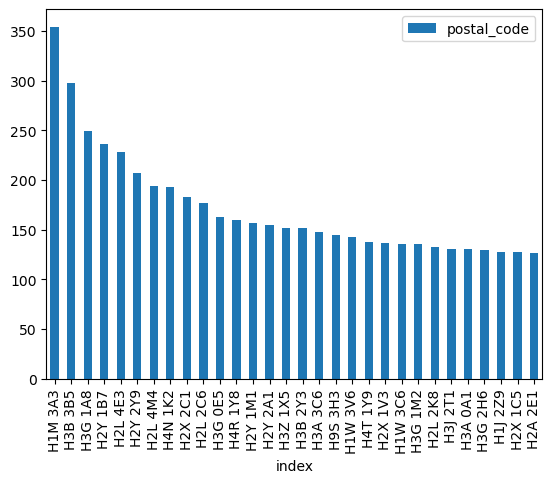

In [66]:
mt_data["postal_code"].value_counts().reset_index().head(30).\
    plot(x="index", y="postal_code", kind="bar")

I will split it into two fields

In [67]:
mt_data["postal_code_1"] = mt_data["postal_code"].str.split(" ").str.get(0)
print("[postal_code_1]=", mt_data["postal_code_1"].drop_duplicates().shape)
mt_data["postal_code_1"].value_counts()

[postal_code_1]= (101,)


H2L    4720
H1W    4207
H1G    3868
H2X    3791
H1L    3280
       ... 
H9K     135
H4Y     122
H5B     106
H4Z      88
H9E      50
Name: postal_code_1, Length: 101, dtype: int64

In [68]:
mt_data["postal_code_2"] = mt_data["postal_code"].str.split(" ").str.get(1)
print("[postal_code_2]=",mt_data["postal_code_2"].drop_duplicates().shape)
mt_data["postal_code_2"].value_counts()

[postal_code_2]= (1060,)


1S4    649
1M1    635
2A1    635
1N5    615
1J5    590
      ... 
0R5      1
5Y3      1
5L1      1
4N7      1
6A5      1
Name: postal_code_2, Length: 1060, dtype: int64

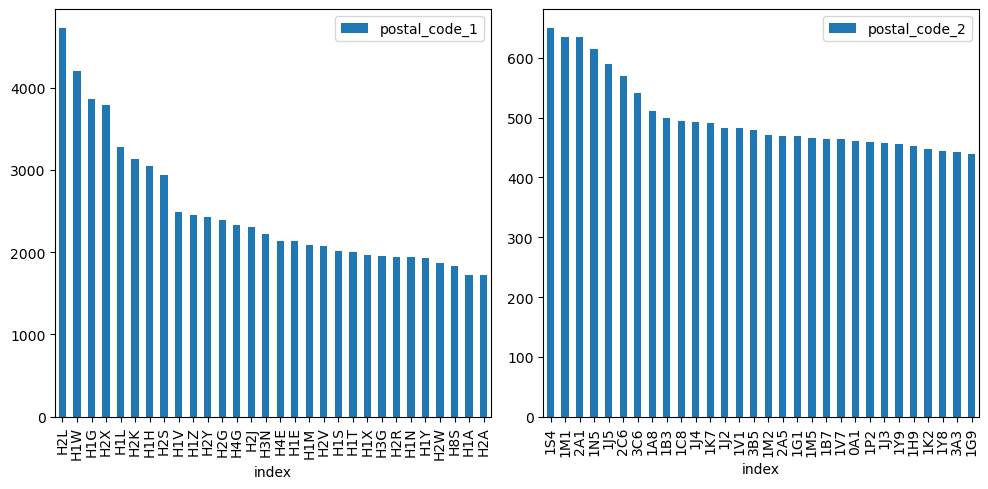

In [69]:
fig, axes = plt.subplots(nrows = 1, ncols=2, figsize = (10, 5))
mt_data["postal_code_1"].value_counts().reset_index().head(30).\
    plot(x="index", y="postal_code_1", kind="bar", ax = axes[0])
mt_data["postal_code_2"].value_counts().reset_index().head(30).\
    plot(x="index", y="postal_code_2", kind="bar", ax = axes[1])
plt.tight_layout()

As in SF data, I will use 200 entries for each part of the post code

In [70]:
psc1_counts = mt_data.postal_code_1.value_counts().head(200)
mt_data["pc1"] = mt_data.apply(lambda r: 
                                     r["postal_code_1"] if r["postal_code_1"] in psc1_counts.index else "other", axis=1)
mt_data.pc1.drop_duplicates().shape

(101,)

In [71]:
psc2_counts = mt_data.postal_code_2.value_counts().head(200)
mt_data["pc2"] = mt_data.apply(lambda r: 
                                     r["postal_code_2"] if r["postal_code_2"] in psc2_counts.index else "other", axis=1)
mt_data.pc2.drop_duplicates().shape

(201,)

### Crime Categories

In [72]:
mt_data.category.value_counts()

Home Invasion                      43354
Theft in / from a motor vehicle    35382
Mischief                           31385
Motor vehicle theft                18723
Confirmed Theft                     7676
Offenses resulting in death          122
Name: category, dtype: int64

In [73]:
mt_violent = ['Offenses resulting in death', 'Theft in / from a motor vehicle', 'Confirmed Theft', 'Mischief']
n_violent = sum(mt_data.category.isin(mt_violent))
print("violent: {} ({:.0f})%".format(n_violent, 100*n_violent/mt_data.shape[0]))
mt_data["violent"] = mt_data.category.isin(mt_violent)

violent: 74565 (55)%


### Visualization

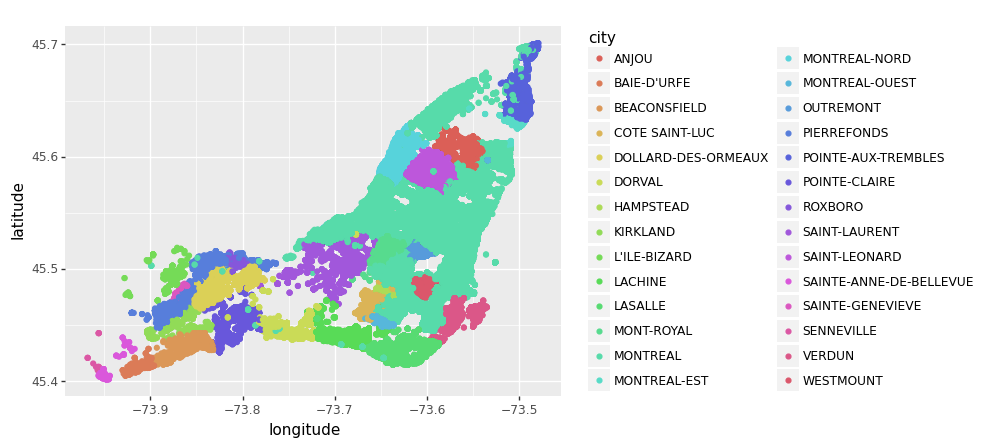

<ggplot: (421056413)>

In [79]:
(
    ggplot(mt_data, aes(x="longitude", y="latitude", color = "city")) +geom_point()
)

In [84]:
psc1_counts.index[0]

'H2L'

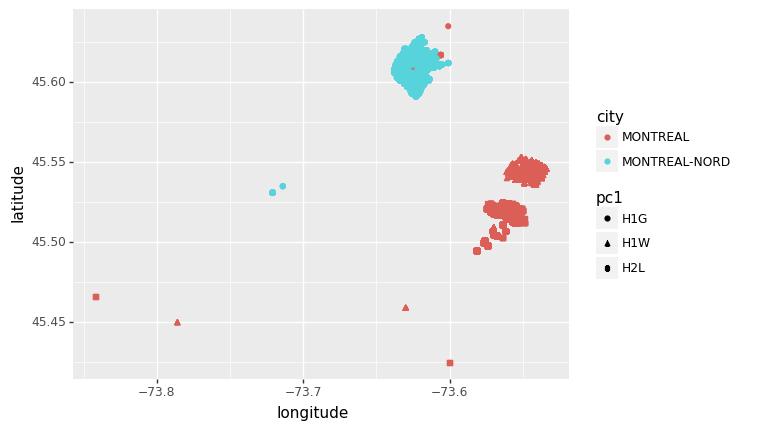

<ggplot: (423519345)>

In [100]:
(
ggplot(mt_data[mt_data.pc1.isin(psc1_counts.index[:3])], aes(x="longitude", y="latitude", color = "city", shape = "pc1")) +
    geom_point()
)

## Saving

In [98]:
mt_data.to_csv("../data/cleaned_data/MontReal.csv")

To work with this data set you should remove such columns as Dates, Category, Address, street1, street2 and make dummies from the others

To work with this data set you should remove such columns as date, category, postal_code, postal_code_1, postal_code_1 and make dummies from the others

In [81]:
mt_data.columns

Index(['category', 'date', 'postal_code', 'city', 'neighbourhood', 'year',
       'count', 'longitude', 'latitude', 'month', 'day', 'hour', 'DayOfWeek',
       'postal_code_1', 'postal_code_2', 'pc1', 'pc2', 'violent'],
      dtype='object')

# Denver

## Loading 

In [4]:
denver = pd.read_csv("../data/external/Denver/crime.csv", encoding = "ISO-8859-1")
denver

,incident_id,offense_id,OFFENSE_CODE,OFFENSE_CODE_EXTENSION,OFFENSE_TYPE_ID,OFFENSE_CATEGORY_ID,FIRST_OCCURRENCE_DATE,LAST_OCCURRENCE_DATE,REPORTED_DATE,INCIDENT_ADDRESS,GEO_X,GEO_Y,GEO_LON,GEO_LAT,DISTRICT_ID,PRECINCT_ID,NEIGHBORHOOD_ID,IS_CRIME,IS_TRAFFIC,VICTIM_COUNT
0,2017421909,2017421909299900,2999,0,criminal-mischief-other,public-disorder,6/25/2017 8:40:00 PM,NaN,6/27/2017 7:01:00 PM,2920 W 32ND AVE,3133773.0,1702660.0,-105.024167,39.761646,1,113,highland,1,0,1
1,2017342682,2017342682299900,2999,0,criminal-mischief-other,public-disorder,5/26/2017 7:00:00 PM,NaN,5/26/2017 11:04:00 PM,13400 E ALBROOK DR,3185904.0,1709037.0,-104.838576,39.778256,5,521,montbello,1,0,1
2,2017421829,2017421829299900,2999,0,criminal-mischief-other,public-disorder,6/27/2017 4:40:00 PM,NaN,6/27/2017 5:50:00 PM,1600 BLOCK 16TH ST,3140436.0,1699005.0,-105.000538,39.751514,6,612,union-station,1,0,1
3,2017342681,2017342681299900,2999,0,criminal-mischief-other,public-disorder,5/26/2017 7:01:00 PM,NaN,5/26/2017 10:21:00 PM,2200 BLOCK MARKET ST,3143338.0,1700561.0,-104.990186,39.755741,6,612,five-points,1,0,1
4,2017448789,2017448789299900,2999,0,criminal-mischief-other,public-disorder,7/7/2017 9:48:00 PM,NaN,7/7/2017 9:48:00 PM,1733 N GROVE ST,3132994.0,1696487.0,-105.027052,39.744711,1,121,west-colfax,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399567,2022510783,2022510783240400,2404,0,theft-of-motor-vehicle,auto-theft,10/2/2022 9:30:00 PM,10/3/2022 6:30:00 AM,10/3/2022 5:33:00 PM,934 16TH ST,3142109.0,1697318.0,-104.994621,39.746857,6,611,cbd,1,0,1
399568,2022510866,2022510866240400,2404,0,theft-of-motor-vehicle,auto-theft,10/3/2022 2:15:00 PM,NaN,10/3/2022 6:09:00 PM,4905 N CATHAY ST,3206327.0,1712283.0,-104.765823,39.786736,5,523,gateway-green-valley-ranch,1,0,1
399569,2022510341,2022510341250100,2501,0,forgery-checks,white-collar-crime,8/3/2022 12:01:00 PM,9/8/2022 9:01:00 PM,10/3/2022 11:53:00 AM,1551S S ROSLYN ST,3168587.0,1676396.0,-104.900952,39.688981,3,322,indian-creek,1,0,1
399570,2022510188,2022510188260500,2605,0,theft-unauth-use-of-ftd,white-collar-crime,7/17/2022 10:16:00 AM,10/3/2022 10:16:00 AM,10/3/2022 10:16:00 AM,1727 N PEARL ST,3146166.0,1696259.0,-104.980215,39.743887,6,621,north-capitol-hill,1,0,1


In [189]:
denver.columns

Index(['incident_id', 'offense_id', 'OFFENSE_CODE', 'OFFENSE_CODE_EXTENSION',
       'OFFENSE_TYPE_ID', 'OFFENSE_CATEGORY_ID', 'FIRST_OCCURRENCE_DATE',
       'LAST_OCCURRENCE_DATE', 'REPORTED_DATE', 'INCIDENT_ADDRESS', 'GEO_X',
       'GEO_Y', 'GEO_LON', 'GEO_LAT', 'DISTRICT_ID', 'PRECINCT_ID',
       'NEIGHBORHOOD_ID', 'IS_CRIME', 'IS_TRAFFIC', 'VICTIM_COUNT'],
      dtype='object')

## Selecting Fields

As you can see, there are lots of NaNs in the LAST_OCCURRENCE_DATE field, some in geographical

In [241]:
100*denver.isna().sum(axis = 0).sort_values(ascending=False)/denver.shape[0]

LAST_OCCURRENCE_DATE      48.637042
street                     1.406255
GEO_LAT                    1.391489
GEO_LON                    1.391489
GEO_Y                      1.391489
GEO_X                      1.391489
INCIDENT_ADDRESS           1.391489
NEIGHBORHOOD_ID            1.333927
DISTRICT_ID                0.365641
IS_CRIME                   0.000000
month                      0.000000
day                        0.000000
hour                       0.000000
DayOfWeek                  0.000000
VICTIM_COUNT               0.000000
IS_TRAFFIC                 0.000000
year                       0.000000
incident_id                0.000000
PRECINCT_ID                0.000000
offense_id                 0.000000
REPORTED_DATE              0.000000
FIRST_OCCURRENCE_DATE      0.000000
OFFENSE_CATEGORY_ID        0.000000
OFFENSE_TYPE_ID            0.000000
OFFENSE_CODE_EXTENSION     0.000000
OFFENSE_CODE               0.000000
str                        0.000000
dtype: float64

I will drop the LAST_OCCURRENCE_DATE column and all rows with NaNs in the rest. Only 3% of data will be dropped

In [246]:
denver.drop(columns=["LAST_OCCURRENCE_DATE"]).dropna().shape[0]/denver.shape[0]

0.9732588870090997

In [247]:
denver = denver.drop(columns=["LAST_OCCURRENCE_DATE"]).dropna()

### Date

In [248]:
denver["FIRST_OCCURRENCE_DATE"] = pd.to_datetime(denver["FIRST_OCCURRENCE_DATE"])

In [249]:
denver["year"] = denver["FIRST_OCCURRENCE_DATE"].dt.year
denver["month"] = denver["FIRST_OCCURRENCE_DATE"].dt.month
denver["day"] = denver["FIRST_OCCURRENCE_DATE"].dt.day
denver["hour"] = denver["FIRST_OCCURRENCE_DATE"].dt.hour
denver["DayOfWeek"] = denver["FIRST_OCCURRENCE_DATE"].dt.dayofweek

### Address and Streets

In [251]:
denver["street"] = denver["INCIDENT_ADDRESS"].str.split(" ").str.get(-2)
denver["street"].drop_duplicates().shape[0]

1066

<AxesSubplot: >

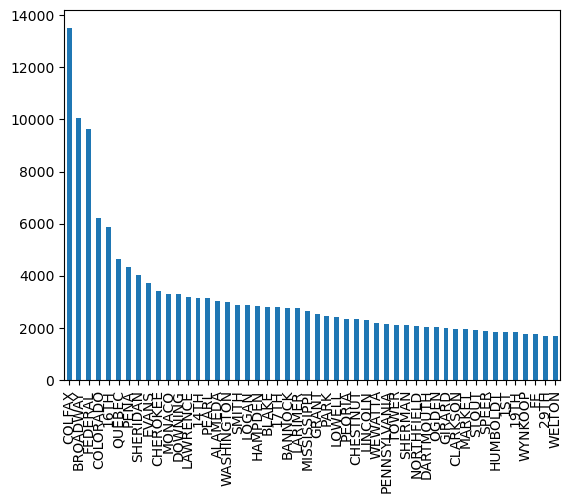

In [252]:
denver["street"].value_counts().head(50).plot(kind="bar")

In [253]:
str_counts = denver["street"].value_counts().head(200)
denver["str"] = denver.apply(lambda r: 
                                     r["street"] if r["street"] in str_counts.index else "other", axis=1)

### Dropping Strange coordinates

Most of the points have 0.1e7 < GEO_X < 1e7

<AxesSubplot: xlabel='GEO_X', ylabel='GEO_Y'>

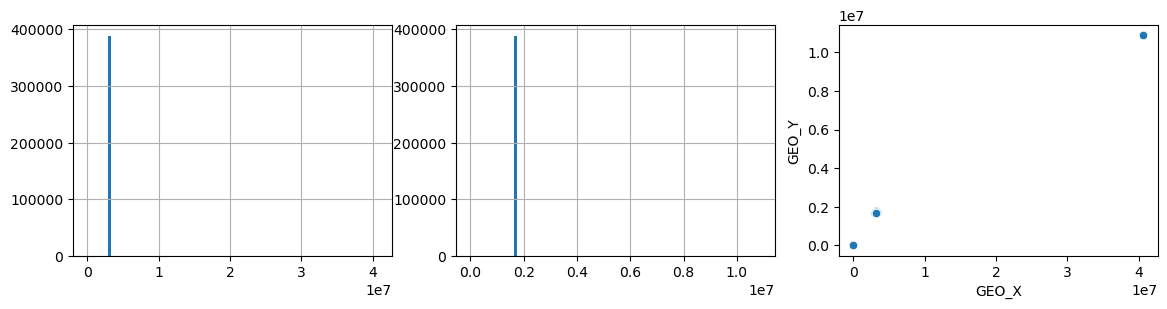

In [254]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (14, 3))
denver["GEO_X"].hist(bins = 100, ax = axes[0])
denver["GEO_Y"].hist(bins = 100, ax = axes[1])
sns.scatterplot(data = denver, x="GEO_X", y="GEO_Y", ax = axes[2])

The others seem to have some strange coordinates, so I will drop them

In [258]:
denver.query("~(0.1e7<GEO_X<0.5e7)")[["GEO_X", "GEO_Y"]]

,GEO_X,GEO_Y
16149,40674765.0,10890451.0
24439,40674765.0,10890451.0
36381,40674765.0,10890451.0
50572,40674765.0,10890451.0
53520,40674765.0,10890451.0
58531,40674765.0,10890451.0
60714,0.0,0.0
60727,0.0,0.0
61455,0.0,0.0
61935,0.0,0.0


In [259]:
_.shape[0]

11

In [260]:
denver = denver.query("0.1e7<GEO_X<0.5e7")

Here is the scatter plot of the points colored by districts

<AxesSubplot: xlabel='GEO_X', ylabel='GEO_Y'>

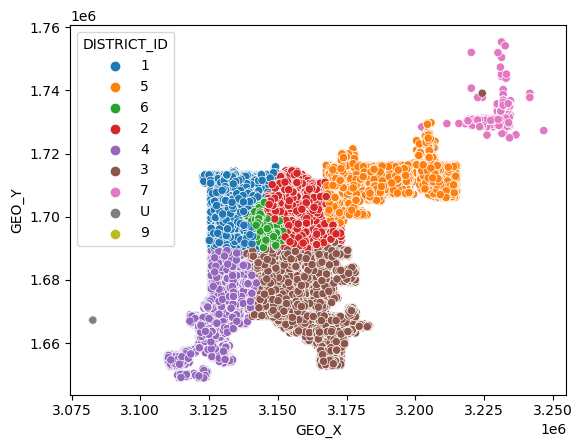

In [261]:
sns.scatterplot(x="GEO_X", y="GEO_Y", data=denver[(denver["GEO_X"]<4e7) & (denver["GEO_X"]>0.1e7)], hue = 'DISTRICT_ID')

In [262]:
denver.columns

Index(['incident_id', 'offense_id', 'OFFENSE_CODE', 'OFFENSE_CODE_EXTENSION',
       'OFFENSE_TYPE_ID', 'OFFENSE_CATEGORY_ID', 'FIRST_OCCURRENCE_DATE',
       'REPORTED_DATE', 'INCIDENT_ADDRESS', 'GEO_X', 'GEO_Y', 'GEO_LON',
       'GEO_LAT', 'DISTRICT_ID', 'PRECINCT_ID', 'NEIGHBORHOOD_ID', 'IS_CRIME',
       'IS_TRAFFIC', 'VICTIM_COUNT', 'year', 'month', 'day', 'hour',
       'DayOfWeek', 'street', 'str'],
      dtype='object')

There is almost 1-1 correspondence between GEO_X and GEO_LON, GEO_Y and GEO_LAT, so I can drop some of the fields

<AxesSubplot: xlabel='GEO_Y', ylabel='GEO_LAT'>

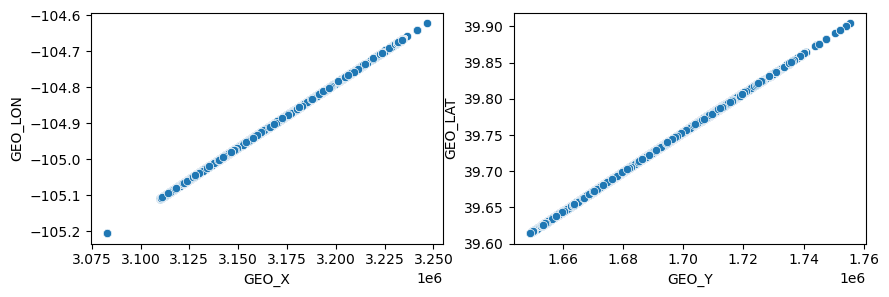

In [270]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 3))
sns.scatterplot(data = denver, x="GEO_X", y="GEO_LON", ax = axes[0])
sns.scatterplot(data = denver, x="GEO_Y", y="GEO_LAT", ax = axes[1])

In [272]:
denver = denver.drop(columns = ["GEO_LON", "GEO_LAT"])
denver.columns

Index(['incident_id', 'offense_id', 'OFFENSE_CODE', 'OFFENSE_CODE_EXTENSION',
       'OFFENSE_TYPE_ID', 'OFFENSE_CATEGORY_ID', 'FIRST_OCCURRENCE_DATE',
       'REPORTED_DATE', 'INCIDENT_ADDRESS', 'GEO_X', 'GEO_Y', 'DISTRICT_ID',
       'PRECINCT_ID', 'NEIGHBORHOOD_ID', 'IS_CRIME', 'IS_TRAFFIC',
       'VICTIM_COUNT', 'year', 'month', 'day', 'hour', 'DayOfWeek', 'street',
       'str'],
      dtype='object')

### Crime Categories

In [298]:
denver[["incident_id", "offense_id", "OFFENSE_CODE", "OFFENSE_CODE_EXTENSION", "OFFENSE_TYPE_ID", "OFFENSE_CATEGORY_ID"]]

,incident_id,offense_id,OFFENSE_CODE,OFFENSE_CODE_EXTENSION,OFFENSE_TYPE_ID,OFFENSE_CATEGORY_ID
0,2017421909,2017421909299900,2999,0,criminal-mischief-other,public-disorder
1,2017342682,2017342682299900,2999,0,criminal-mischief-other,public-disorder
2,2017421829,2017421829299900,2999,0,criminal-mischief-other,public-disorder
3,2017342681,2017342681299900,2999,0,criminal-mischief-other,public-disorder
4,2017448789,2017448789299900,2999,0,criminal-mischief-other,public-disorder
...,...,...,...,...,...,...
399567,2022510783,2022510783240400,2404,0,theft-of-motor-vehicle,auto-theft
399568,2022510866,2022510866240400,2404,0,theft-of-motor-vehicle,auto-theft
399569,2022510341,2022510341250100,2501,0,forgery-checks,white-collar-crime
399570,2022510188,2022510188260500,2605,0,theft-unauth-use-of-ftd,white-collar-crime


As you can see, **offense_id** is combination of incident_id, OFFENSE_CODE, OFFENSE_CODE_EXTENSION, so I will drop 

In [309]:
np.all(
   10**6*denver["incident_id"] + 10**2*denver["OFFENSE_CODE"] + denver["OFFENSE_CODE_EXTENSION"] == denver["offense_id"]
)

True

In [310]:
denver = denver.drop(columns=["offense_id"])

Number of distinct incident_id values is huge, so I drop it too

In [313]:
denver["incident_id"].drop_duplicates().shape[0]/denver.shape[0]

0.9259738322755839

In [314]:
denver = denver.drop(columns = ["incident_id"])

In [315]:
denver["OFFENSE_CODE_EXTENSION"].drop_duplicates()

0         0
2407      1
5187      2
21910     3
21949     4
53576     5
377534    6
Name: OFFENSE_CODE_EXTENSION, dtype: int64

It is probably better to leave only OFFENSE_CATEGORY_ID and make conclusion about the violence using it

In [317]:
denver["OFFENSE_CATEGORY_ID"].drop_duplicates()

0                     public-disorder
5732                     drug-alcohol
10336    other-crimes-against-persons
10531                all-other-crimes
23256                          murder
24126                         robbery
29862              aggravated-assault
32983                           arson
33119                        burglary
37545                         larceny
40050        theft-from-motor-vehicle
53572                      auto-theft
59085              white-collar-crime
Name: OFFENSE_CATEGORY_ID, dtype: object

In [318]:
denver.columns

Index(['OFFENSE_CODE', 'OFFENSE_CODE_EXTENSION', 'OFFENSE_TYPE_ID',
       'OFFENSE_CATEGORY_ID', 'FIRST_OCCURRENCE_DATE', 'REPORTED_DATE',
       'INCIDENT_ADDRESS', 'GEO_X', 'GEO_Y', 'DISTRICT_ID', 'PRECINCT_ID',
       'NEIGHBORHOOD_ID', 'IS_CRIME', 'IS_TRAFFIC', 'VICTIM_COUNT', 'year',
       'month', 'day', 'hour', 'DayOfWeek', 'street', 'str'],
      dtype='object')

In [320]:
denver = denver.drop(columns = ['OFFENSE_CODE', 'OFFENSE_CODE_EXTENSION', 'OFFENSE_TYPE_ID'])
denver.columns

Index(['OFFENSE_CATEGORY_ID', 'FIRST_OCCURRENCE_DATE', 'REPORTED_DATE',
       'INCIDENT_ADDRESS', 'GEO_X', 'GEO_Y', 'DISTRICT_ID', 'PRECINCT_ID',
       'NEIGHBORHOOD_ID', 'IS_CRIME', 'IS_TRAFFIC', 'VICTIM_COUNT', 'year',
       'month', 'day', 'hour', 'DayOfWeek', 'street', 'str'],
      dtype='object')

I also do not need some other fields

In [321]:
denver = denver.drop(columns = ["IS_CRIME", 'IS_TRAFFIC', 'VICTIM_COUNT'])
denver.columns

Index(['OFFENSE_CATEGORY_ID', 'FIRST_OCCURRENCE_DATE', 'REPORTED_DATE',
       'INCIDENT_ADDRESS', 'GEO_X', 'GEO_Y', 'DISTRICT_ID', 'PRECINCT_ID',
       'NEIGHBORHOOD_ID', 'year', 'month', 'day', 'hour', 'DayOfWeek',
       'street', 'str'],
      dtype='object')

In [322]:
denver = denver.drop(columns = ['FIRST_OCCURRENCE_DATE', 'REPORTED_DATE',])
denver.columns

Index(['OFFENSE_CATEGORY_ID', 'INCIDENT_ADDRESS', 'GEO_X', 'GEO_Y',
       'DISTRICT_ID', 'PRECINCT_ID', 'NEIGHBORHOOD_ID', 'year', 'month', 'day',
       'hour', 'DayOfWeek', 'street', 'str'],
      dtype='object')

### Selecting Violents

In [325]:
denver_cat_sums = denver["OFFENSE_CATEGORY_ID"].value_counts()
denver_cat_sums

theft-from-motor-vehicle        58615
public-disorder                 58065
all-other-crimes                55962
larceny                         55925
auto-theft                      48937
burglary                        27470
other-crimes-against-persons    26200
drug-alcohol                    25256
aggravated-assault              17053
robbery                          7131
white-collar-crime               7013
arson                             838
murder                            411
Name: OFFENSE_CATEGORY_ID, dtype: int64

In [339]:
denver_violent_list = ["public-disorder", "burglary", "robbery", "larceny", "murder"]
denver_nonviolent_list = [c for c in denver_cat_sums.index if not c in denver_violent_list]
n_v = denver_cat_sums[denver_violent_list].sum()
n_nv = denver_cat_sums[denver_nonviolent_list].sum()
print("Violent: ", n_v, " vs NonViolent ", n_nv, " n_v/n_nv=", n_v/n_nv)

Violent:  149002  vs NonViolent  239874  n_v/n_nv= 0.621167779751036


In [341]:
denver["violent"] = denver["OFFENSE_CATEGORY_ID"].isin(denver_violent_list)

In [342]:
denver.dtypes

OFFENSE_CATEGORY_ID     object
INCIDENT_ADDRESS        object
GEO_X                  float64
GEO_Y                  float64
DISTRICT_ID             object
PRECINCT_ID              int64
NEIGHBORHOOD_ID         object
year                     int64
month                    int64
day                      int64
hour                     int64
DayOfWeek                int64
street                  object
str                     object
violent                   bool
dtype: object

### Saving

In [345]:
denver.to_csv("../data/cleaned_data/denver.csv")

# Philadelphia 

In [5]:
phil_data = pd.read_csv("../data/external/Philadelphia.csv")
phil_data

,Dc_Dist,Psa,Dispatch_Date_Time,Dispatch_Date,Dispatch_Time,Hour,Dc_Key,Location_Block,UCR_General,Text_General_Code,Police_Districts,Month,Lon,Lat
0,18,3,2009-10-02 14:24:00,2009-10-02,14:24:00,14,200918067518,S 38TH ST / MARKETUT ST,800.0,Other Assaults,NaN,2009-10,NaN,NaN
1,14,1,2009-05-10 00:55:00,2009-05-10,00:55:00,0,200914033994,8500 BLOCK MITCH,2600.0,All Other Offenses,NaN,2009-05,NaN,NaN
2,25,J,2009-08-07 15:40:00,2009-08-07,15:40:00,15,200925083199,6TH CAMBRIA,800.0,Other Assaults,NaN,2009-08,NaN,NaN
3,35,D,2009-07-19 01:09:00,2009-07-19,01:09:00,1,200935061008,5500 BLOCK N 5TH ST,1500.0,Weapon Violations,20.0,2009-07,-75.130477,40.036389
4,9,R,2009-06-25 00:14:00,2009-06-25,00:14:00,0,200909030511,1800 BLOCK WYLIE ST,2600.0,All Other Offenses,8.0,2009-06,-75.166350,39.969532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2237600,1,1,2017-01-17 09:13:00,2017-01-17,09:13:00,9,201701002678,2100 BLOCK S BROAD ST,2600.0,All Other Offenses,1.0,2017-01,-75.169992,39.923556
2237601,16,1,2017-01-17 22:35:00,2017-01-17,22:35:00,22,201716002117,N 38TH ST / WALLACE ST,2600.0,All Other Offenses,12.0,2017-01,-75.197627,39.964593
2237602,16,1,2017-01-17 22:35:00,2017-01-17,22:35:00,22,201716002118,N 38TH ST / WALLACE ST,2600.0,All Other Offenses,12.0,2017-01,-75.197627,39.964593
2237603,19,2,2017-01-18 01:23:00,2017-01-18,01:23:00,1,201719004939,6000 BLOCK HAVERFORD AV,2600.0,All Other Offenses,15.0,2017-01,-75.240163,39.970507
